# Project : Undersampled MRI Reconstruction

**Importing Dependencies**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Writing Basic Functions**

This function converts data from image domain to frequency domain (Image to Kspace)

In [2]:
def citf(image):
    tmp = np.fft.fftshift(cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT))
    complex_matrix = tmp[:,:,0] + 1j * tmp[:,:,1]
    return complex_matrix


This function converts data from frequency domain to Image domain (Kspace to Image)

In [3]:
def cfti(kspace):
    img_inverse = np.flipud(np.fliplr(np.abs(np.fft.ifft2(kspace))))
    return img_inverse

This function takes kspace as input and displays the data in both the image and frequency domain

In [4]:
def show_both(kspace):
    mag_spe = 20*np.log(np.abs(kspace))
    plt.subplot(121), plt.imshow(cfti(kspace), cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(mag_spe, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

This function takes two kspace data and display their images

In [5]:
def diff(t_kspace , u_kspace):
    plt.subplot(121), plt.imshow(cfti(t_kspace), cmap='gray')
    plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cfti(u_kspace), cmap='gray')
    plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
    plt.show()

# Data Collection

This part we read the data from the kaggle dataset and store in an numpy array so that we can work on it

In [2]:
images = []
def process_file(file_path):
    if "mask" in file_path or "README" in file_path or ".csv" in file_path:
        time.sleep(0)
    else:
        image = cv2.imread(file_path,0)
        image = np.array(image)
        image = image.astype('float32') / 255.0
        images.append(image)
        return
for folder_name, subfolders, filenames in os.walk("/kaggle/input/lgg-mri-segmentation/kaggle_3m"):
    for filename in filenames:
        if "mask" not in filename:
            file_path = os.path.join(folder_name, filename)
            process_file(file_path)
images = np.asarray(images)

# Data preprocessing

Since we want to undersample our data therefore we need to convert our data from image to frequency domain

In [ ]:
kspaces = []
for image in images:
    kspace = citf(image)
    kspaces.append(np.array(kspace))
kspaces = np.asarray(kspaces)

# Undersampling the kspace data

Now we need to undersample our data.

**For this we need to undersample our data in such a way which will decrease the acquisition time and also it is feasible to collect that undersampled data from MRI machine**

Therefore we have chosen an cartesian undersampling.

Preparing mask to undersample the kspace data.

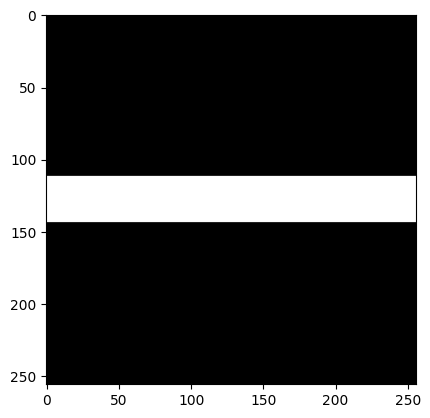

In [6]:
mask = np.zeros((256,256))
mask[112:144,:] = np.ones((32,256))
plt.imshow(mask, cmap='gray')

In [4]:
def unsample_data(data, mask):
    u_kspaces = []
    u_images = []
    for i in range(kspaces.shape[0]):
        u_kspace = np.multiply(kspaces[i,:,:], mask)
        u_kspaces.append(u_kspace)
        u_images.append(cfti(u_kspace))
    return np.array(u_kspaces) , np.array(u_images)

In [5]:
u_kspaces , u_images = unsample_data(kspaces,mask)

At this stage we have preprocessed the data and we have fullysampled kspaces , their corresponding images , undersampled kspaces and their corresponding images.

**We will store this in a file so that we don't require to do this much processing again and again. We will directly read this data from this file if we want to use it again.**

In [6]:
np.savez('data.npz',kspaces=kspaces , u_kspaces = u_kspaces , images=images , u_images=u_images)

In [8]:
import numpy as np
data = np.load('data.npz')
kspaces = data['kspaces']
u_kspaces = data['u_kspaces']
images = data['images']
u_images = data['u_images']

**This example shows the undersampled kspace and its corresponding image**

**You can notice that the image is blurred and most of the fine details of the MRI images are gone**

/tmp/ipykernel_1909/3086757226.py:2: RuntimeWarning: divide by zero encountered in log
  mag_spe = 20*np.log(np.abs(kspace))


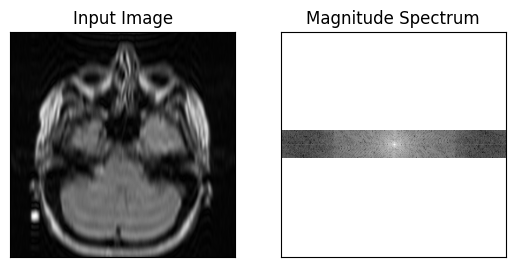

In [9]:
show_both(u_kspaces[100,:,:])

**Comparison between Fullysampled MRI image and Undersampled MRI image**

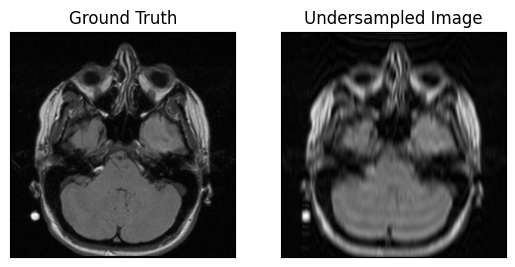

In [10]:
diff(kspaces[100,:,:],u_kspaces[100,:,:])

# Spliting the Data into train and test data

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(u_images , images , test_size=0.2, random_state=42)

# Creating a model architechture

This model is being inspired from the **ReconResNet: Regularised Residual Learning for MR Image Reconstruction of Undersampled Cartesian and Radial Data**

Link of the paper : https://arxiv.org/pdf/2103.09203.pdf

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def res_block(x, filters, kernel_size=3, stride=1, padding='same'):
    """Residual block."""
    res = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, res])
    x = layers.Activation('relu')(x)
    return x

def ResNet(input_shape, num_residual_blocks):
    """Builds the ResNet."""
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Input Down-sampling
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Residual Blocks
    for _ in range(num_residual_blocks):
        x = res_block(x, 64)
    
    # Output Up-sampling
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Final Convolution Layer
    outputs = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid')(x)
    
    # Define the model
    model = models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=ssim_loss)
    
    return model

# Set input shape and number of residual blocks based on the paper
input_shape = (256,256, 1)  # Assuming grayscale MRI images with variable size
num_residual_blocks = 34

# Create the model
model = ResNet(input_shape, num_residual_blocks)

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

# Training the model

In [16]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=25)

Epoch 1/25
79/79 [==============================] - 106s 561ms/step - loss: 0.3196 - val_loss: 0.9985
Epoch 2/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0977 - val_loss: 0.5214
Epoch 3/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0777 - val_loss: 0.3939
Epoch 4/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0639 - val_loss: 0.1578
Epoch 5/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0632 - val_loss: 0.0792
Epoch 6/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0594 - val_loss: 0.1025
Epoch 7/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0665 - val_loss: 0.3020
Epoch 8/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0554 - val_loss: 0.1141
Epoch 9/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0495 - val_loss: 0.0978
Epoch 10/25
79/79 [==============================] - 39s 495ms/step - loss: 0.0524 - val_l

In [18]:
model.save_weights('model25.h5')

In [20]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

[0.9985066056251526, 0.5213621854782104, 0.39390361309051514, 0.15777525305747986, 0.07915116101503372, 0.1024715006351471, 0.301967978477478, 0.11413514614105225, 0.09777098149061203, 0.04964987561106682, 0.0503963828086853, 0.04640861973166466, 0.04135964438319206, 0.07967519760131836, 0.04618353396654129, 0.061723742634058, 0.11988164484500885, 0.0766148567199707, 0.05857740715146065, 0.04526172950863838, 0.03969277814030647, 0.06551457196474075, 0.1307910978794098, 0.05465428903698921, 0.09197985380887985]
[0.3195965588092804, 0.09773796051740646, 0.07774664461612701, 0.0639001652598381, 0.063180111348629, 0.05941503122448921, 0.0665377527475357, 0.05535587668418884, 0.04949125647544861, 0.052389711141586304, 0.05155612900853157, 0.05085379630327225, 0.04483596980571747, 0.04991057142615318, 0.04445385932922363, 0.04387463629245758, 0.047068819403648376, 0.047843776643276215, 0.04213350638747215, 0.042079053819179535, 0.046697720885276794, 0.041968006640672684, 0.04785532504320145,

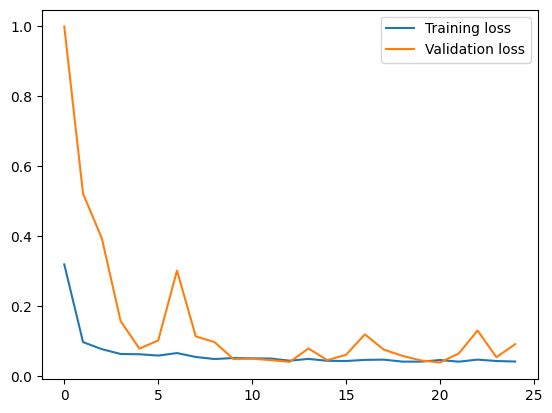

In [22]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

In [15]:
model.load_weights('model25.h5')

In [41]:
output_images = model.predict(X_test)

25/25 [==============================] - 3s 114ms/step


# Post processing

**Finding the inverse mask**

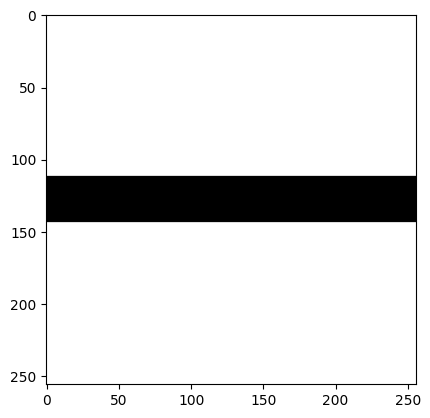

In [42]:
# Finding the inverse of mask
inv_mask = np.ones((256,256))
inv_mask[112:144,:] = np.zeros((32,256))
plt.imshow(inv_mask,cmap='gray')

* Multiply the inverse to the kspace obtained from the output image of model 
* Add this obtained result to the undersampled kspace to get the fully sampled kspace
* Inverse Fourier transform to convert data from frequency domain to image domain

This is the final output of the algorithm


In [43]:
recon_kspaces = []
recon_images = []
for i in range(len(output_images)):
    r_kspace = np.array(citf(output_images[i]))
    r_kspace = np.multiply(r_kspace , inv_mask)
    r_kspace = r_kspace + citf(X_test[i])
    recon_kspaces.append(r_kspace)
    recon_images.append(cfti(r_kspace))
recon_kspaces = np.asarray(recon_kspaces)
recon_images = np.asarray(recon_images)
    

# Visualizing the output from the model after preprocessing

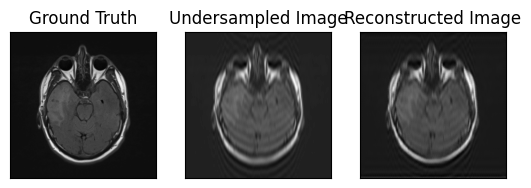

In [60]:
plt.subplot(131), plt.imshow(Y_test[2], cmap='gray')
plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(X_test[2], cmap='gray')
plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(recon_images[2], cmap='gray')
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.show()

# END OF PROJECT PHASE I